## Lab 8: Parameter Tuning for Backpropagation 


#### CSC 180  Intelligent Systems (Fall 2019)

#### Dr. Haiquan Chen, California State University, Sacramento

# Helpful Functions for Tensorflow (Little Gems)

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network. 

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [1]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


# Learning rate
Backpropagation is the primary means by which a neural network's weights are determined during training. Backpropagation works by calculating a weight change amount ($v_t$) for every weight($\theta$, theata) in the neural network.  This value is subtracted from every weight by the following equation: 

$ \theta_t = \theta_{t-1} - v_t $


### The learning rate is an important concept for backpropagation training.  Setting the learning rate can be complex:

* Too low of a learning rate will usually converge to a good solution; however, the process will be very slow.
* Too high of a learning rate will either fail outright, or converge to a higher error than a better learning rate.

#### Common values for learning rate are: 0.1, 0.01, 0.001, etc.


# Batch size

#### Number of samples per gradient update.  In keras, you may set the batch_size parameter in function fit()

https://keras.io/models/model/

batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.

# Update rules (optimizers)

The following image shows how each of these algorithms train (image credits: [author](http://sebastianruder.com/optimizing-gradient-descent/index.html#visualizationofalgorithms) ):

![Training Techniques](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/contours_evaluation_optimizers.gif "Training Techniques")


## An optimizer is one of the two arguments required when you compile a Keras model using compile(). 

Specifying the Update Rule (Optimizer) in Tensorflow

TensorFlow allows the update rule to be set to one of:

* Adagrad
* **Adam**
* Ftrl
* Momentum
* RMSProp
* **SGD**

https://keras.io/optimizers/


You can either instantiate an optimizer or you can call it by its name. In the latter case, the default parameters for the optimizer will be used.

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(10, input_dim=10, activation='relu'))
model.add(Dense(1))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='mean_squared_error', optimizer=sgd)

#### Using all Default Parameters for a Particular Optimizer

In [3]:
# pass optimizer by name: default parameters will be used
model.compile(loss='mean_squared_error', optimizer='sgd')

## A Complete Example:

Train on 318 samples, validate on 80 samples
Epoch 1/1000
318/318 - 1s - loss: 618.5678 - val_loss: 587.2327
Epoch 2/1000
318/318 - 0s - loss: 618.2572 - val_loss: 586.8145
Epoch 3/1000
318/318 - 0s - loss: 617.8846 - val_loss: 586.2677
Epoch 4/1000
318/318 - 0s - loss: 617.3848 - val_loss: 585.6389
Epoch 5/1000
318/318 - 0s - loss: 616.8405 - val_loss: 584.9390
Epoch 6/1000
318/318 - 0s - loss: 616.2495 - val_loss: 584.1628
Epoch 7/1000
318/318 - 0s - loss: 615.5438 - val_loss: 583.3048
Epoch 8/1000
318/318 - 0s - loss: 614.7590 - val_loss: 582.3987
Epoch 9/1000
318/318 - 0s - loss: 613.8702 - val_loss: 581.3989
Epoch 10/1000
318/318 - 0s - loss: 612.8481 - val_loss: 580.3062
Epoch 11/1000
318/318 - 0s - loss: 611.7978 - val_loss: 579.1297
Epoch 12/1000
318/318 - 0s - loss: 610.5891 - val_loss: 577.7399
Epoch 13/1000
318/318 - 0s - loss: 609.3481 - val_loss: 576.2731
Epoch 14/1000
318/318 - 0s - loss: 607.9943 - val_loss: 574.7656
Epoch 15/1000
318/318 - 0s - loss: 606.5213 - val_loss

318/318 - 0s - loss: 311.5181 - val_loss: 286.8229
Epoch 127/1000
318/318 - 0s - loss: 308.7377 - val_loss: 284.1810
Epoch 128/1000
318/318 - 0s - loss: 305.8568 - val_loss: 281.5704
Epoch 129/1000
318/318 - 0s - loss: 303.0652 - val_loss: 278.9645
Epoch 130/1000
318/318 - 0s - loss: 300.3214 - val_loss: 276.3552
Epoch 131/1000
318/318 - 0s - loss: 297.4767 - val_loss: 273.7745
Epoch 132/1000
318/318 - 0s - loss: 294.6738 - val_loss: 271.1953
Epoch 133/1000
318/318 - 0s - loss: 291.9512 - val_loss: 268.6108
Epoch 134/1000
318/318 - 0s - loss: 289.1896 - val_loss: 266.0419
Epoch 135/1000
318/318 - 0s - loss: 286.4014 - val_loss: 263.4884
Epoch 136/1000
318/318 - 0s - loss: 283.6657 - val_loss: 260.9425
Epoch 137/1000
318/318 - 0s - loss: 280.9329 - val_loss: 258.4130
Epoch 138/1000
318/318 - 0s - loss: 278.2310 - val_loss: 255.8945
Epoch 139/1000
318/318 - 0s - loss: 275.4700 - val_loss: 253.4001
Epoch 140/1000
318/318 - 0s - loss: 272.7865 - val_loss: 250.9084
Epoch 141/1000
318/318 - 

Epoch 252/1000
318/318 - 0s - loss: 50.9508 - val_loss: 50.9717
Epoch 253/1000
318/318 - 0s - loss: 50.1247 - val_loss: 50.2676
Epoch 254/1000
318/318 - 0s - loss: 49.3402 - val_loss: 49.5838
Epoch 255/1000
318/318 - 0s - loss: 48.5291 - val_loss: 48.9317
Epoch 256/1000
318/318 - 0s - loss: 47.7732 - val_loss: 48.2899
Epoch 257/1000
318/318 - 0s - loss: 47.0601 - val_loss: 47.6578
Epoch 258/1000
318/318 - 0s - loss: 46.3398 - val_loss: 47.0442
Epoch 259/1000
318/318 - 0s - loss: 45.6433 - val_loss: 46.4496
Epoch 260/1000
318/318 - 0s - loss: 44.9383 - val_loss: 45.8754
Epoch 261/1000
318/318 - 0s - loss: 44.3039 - val_loss: 45.3119
Epoch 262/1000
318/318 - 0s - loss: 43.6530 - val_loss: 44.7667
Epoch 263/1000
318/318 - 0s - loss: 43.0307 - val_loss: 44.2301
Epoch 264/1000
318/318 - 0s - loss: 42.4217 - val_loss: 43.7086
Epoch 265/1000
318/318 - 0s - loss: 41.8454 - val_loss: 43.2015
Epoch 266/1000
318/318 - 0s - loss: 41.2670 - val_loss: 42.7145
Epoch 267/1000
318/318 - 0s - loss: 40.7

318/318 - 0s - loss: 18.2625 - val_loss: 19.2650
Epoch 381/1000
318/318 - 0s - loss: 18.1702 - val_loss: 19.1510
Epoch 382/1000
318/318 - 0s - loss: 18.0856 - val_loss: 19.0356
Epoch 383/1000
318/318 - 0s - loss: 17.9992 - val_loss: 18.9181
Epoch 384/1000
318/318 - 0s - loss: 17.9172 - val_loss: 18.8000
Epoch 385/1000
318/318 - 0s - loss: 17.8323 - val_loss: 18.6840
Epoch 386/1000
318/318 - 0s - loss: 17.7462 - val_loss: 18.5717
Epoch 387/1000
318/318 - 0s - loss: 17.6643 - val_loss: 18.4589
Epoch 388/1000
318/318 - 0s - loss: 17.5813 - val_loss: 18.3459
Epoch 389/1000
318/318 - 0s - loss: 17.4995 - val_loss: 18.2334
Epoch 390/1000
318/318 - 0s - loss: 17.4180 - val_loss: 18.1220
Epoch 391/1000
318/318 - 0s - loss: 17.3396 - val_loss: 18.0106
Epoch 392/1000
318/318 - 0s - loss: 17.2601 - val_loss: 17.9005
Epoch 393/1000
318/318 - 0s - loss: 17.1825 - val_loss: 17.7899
Epoch 394/1000
318/318 - 0s - loss: 17.1021 - val_loss: 17.6804
Epoch 395/1000
318/318 - 0s - loss: 17.0235 - val_loss:

Epoch 509/1000
318/318 - 0s - loss: 11.3813 - val_loss: 9.7504
Epoch 510/1000
318/318 - 0s - loss: 11.3507 - val_loss: 9.7077
Epoch 511/1000
318/318 - 0s - loss: 11.3195 - val_loss: 9.6644
Epoch 512/1000
318/318 - 0s - loss: 11.2914 - val_loss: 9.6199
Epoch 513/1000
318/318 - 0s - loss: 11.2616 - val_loss: 9.5781
Epoch 514/1000
318/318 - 0s - loss: 11.2305 - val_loss: 9.5394
Epoch 515/1000
318/318 - 0s - loss: 11.2025 - val_loss: 9.5001
Epoch 516/1000
318/318 - 0s - loss: 11.1752 - val_loss: 9.4596
Epoch 517/1000
318/318 - 0s - loss: 11.1466 - val_loss: 9.4186
Epoch 518/1000
318/318 - 0s - loss: 11.1164 - val_loss: 9.3791
Epoch 519/1000
318/318 - 0s - loss: 11.0882 - val_loss: 9.3401
Epoch 520/1000
318/318 - 0s - loss: 11.0604 - val_loss: 9.2999
Epoch 521/1000
318/318 - 0s - loss: 11.0332 - val_loss: 9.2592
Epoch 522/1000
318/318 - 0s - loss: 11.0029 - val_loss: 9.2204
Epoch 523/1000
318/318 - 0s - loss: 10.9764 - val_loss: 9.1813
Epoch 524/1000
318/318 - 0s - loss: 10.9507 - val_loss:

318/318 - 0s - loss: 9.0613 - val_loss: 6.7650
Epoch 641/1000
318/318 - 0s - loss: 9.0513 - val_loss: 6.7534
Epoch 642/1000
318/318 - 0s - loss: 9.0442 - val_loss: 6.7429
Epoch 643/1000
318/318 - 0s - loss: 9.0359 - val_loss: 6.7321
Epoch 644/1000
318/318 - 0s - loss: 9.0276 - val_loss: 6.7204
Epoch 645/1000
318/318 - 0s - loss: 9.0205 - val_loss: 6.7101
Epoch 646/1000
318/318 - 0s - loss: 9.0125 - val_loss: 6.6975
Epoch 647/1000
318/318 - 0s - loss: 9.0042 - val_loss: 6.6870
Epoch 648/1000
318/318 - 0s - loss: 8.9971 - val_loss: 6.6760
Epoch 649/1000
318/318 - 0s - loss: 8.9896 - val_loss: 6.6663
Epoch 650/1000
318/318 - 0s - loss: 8.9820 - val_loss: 6.6567
Epoch 651/1000
318/318 - 0s - loss: 8.9738 - val_loss: 6.6481
Epoch 652/1000
318/318 - 0s - loss: 8.9670 - val_loss: 6.6402
Epoch 653/1000
318/318 - 0s - loss: 8.9598 - val_loss: 6.6322
Epoch 654/1000
318/318 - 0s - loss: 8.9523 - val_loss: 6.6239
Epoch 655/1000
318/318 - 0s - loss: 8.9451 - val_loss: 6.6158
Epoch 656/1000
318/318 

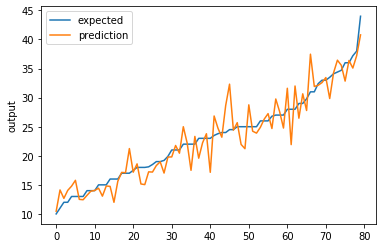

In [5]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

path = "./data/"
preprocess = True

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
encode_text_dummy(df, 'origin')
df.drop('name',1,inplace=True)
if preprocess:
    encode_numeric_zscore(df, 'horsepower')
    encode_numeric_zscore(df, 'weight')
    encode_numeric_zscore(df, 'cylinders')
    encode_numeric_zscore(df, 'displacement')
    encode_numeric_zscore(df, 'acceleration')
    encode_numeric_zscore(df, 'year')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
#model.add(Dense(10, activation='tanh'))   
model.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=adam)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
#checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

# batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 128, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test)

In [9]:
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
#model.add(Dense(10, activation='tanh'))   
model.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=adam)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
#checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

# batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor],verbose=2,epochs=1000)
#model.load_weights('dnn/best_weights.hdf5') # load weights from best model

Train on 318 samples, validate on 80 samples
Epoch 1/1000
318/318 - 1s - loss: 615.5566 - val_loss: 583.4039
Epoch 2/1000
318/318 - 1s - loss: 613.9097 - val_loss: 581.5164
Epoch 3/1000
318/318 - 0s - loss: 612.1221 - val_loss: 579.5286
Epoch 4/1000
318/318 - 0s - loss: 610.2129 - val_loss: 577.4338
Epoch 5/1000
318/318 - 0s - loss: 608.0160 - val_loss: 575.0228
Epoch 6/1000
318/318 - 0s - loss: 605.1377 - val_loss: 571.9579
Epoch 7/1000
318/318 - 0s - loss: 601.5498 - val_loss: 568.0755
Epoch 8/1000
318/318 - 0s - loss: 597.1525 - val_loss: 563.7143
Epoch 9/1000
318/318 - 0s - loss: 591.8561 - val_loss: 558.7035
Epoch 10/1000
318/318 - 0s - loss: 585.5792 - val_loss: 553.0501
Epoch 11/1000
318/318 - 0s - loss: 578.6921 - val_loss: 546.8141
Epoch 12/1000
318/318 - 0s - loss: 571.5493 - val_loss: 540.3800
Epoch 13/1000
318/318 - 0s - loss: 564.1987 - val_loss: 534.0105
Epoch 14/1000
318/318 - 0s - loss: 557.1208 - val_loss: 527.5439
Epoch 15/1000
318/318 - 0s - loss: 549.9641 - val_loss

Epoch 128/1000
318/318 - 0s - loss: 20.6330 - val_loss: 23.5147
Epoch 129/1000
318/318 - 0s - loss: 20.3646 - val_loss: 23.1348
Epoch 130/1000
318/318 - 0s - loss: 20.0883 - val_loss: 22.7730
Epoch 131/1000
318/318 - 0s - loss: 19.8214 - val_loss: 22.4287
Epoch 132/1000
318/318 - 0s - loss: 19.5542 - val_loss: 22.0747
Epoch 133/1000
318/318 - 0s - loss: 19.3085 - val_loss: 21.7178
Epoch 134/1000
318/318 - 0s - loss: 19.0464 - val_loss: 21.3755
Epoch 135/1000
318/318 - 0s - loss: 18.8030 - val_loss: 21.0351
Epoch 136/1000
318/318 - 0s - loss: 18.5394 - val_loss: 20.7268
Epoch 137/1000
318/318 - 0s - loss: 18.3091 - val_loss: 20.3975
Epoch 138/1000
318/318 - 0s - loss: 18.0844 - val_loss: 20.0854
Epoch 139/1000
318/318 - 0s - loss: 17.8472 - val_loss: 19.7530
Epoch 140/1000
318/318 - 0s - loss: 17.6062 - val_loss: 19.4618
Epoch 141/1000
318/318 - 0s - loss: 17.3989 - val_loss: 19.1442
Epoch 142/1000
318/318 - 0s - loss: 17.1670 - val_loss: 18.8497
Epoch 143/1000
318/318 - 0s - loss: 16.9

318/318 - 0s - loss: 8.5402 - val_loss: 6.3365
Epoch 259/1000
318/318 - 0s - loss: 8.5381 - val_loss: 6.3127
Epoch 260/1000
318/318 - 0s - loss: 8.5178 - val_loss: 6.3045
Epoch 261/1000
318/318 - 0s - loss: 8.5096 - val_loss: 6.2970
Epoch 262/1000
318/318 - 0s - loss: 8.5045 - val_loss: 6.2862
Epoch 263/1000
318/318 - 0s - loss: 8.4951 - val_loss: 6.2834
Epoch 264/1000
318/318 - 0s - loss: 8.4840 - val_loss: 6.2646
Epoch 265/1000
318/318 - 0s - loss: 8.4783 - val_loss: 6.2509
Epoch 266/1000
318/318 - 0s - loss: 8.4683 - val_loss: 6.2347
Epoch 267/1000
318/318 - 0s - loss: 8.4704 - val_loss: 6.2394
Epoch 268/1000
318/318 - 0s - loss: 8.4495 - val_loss: 6.2219
Epoch 269/1000
318/318 - 0s - loss: 8.4554 - val_loss: 6.1937
Epoch 270/1000
318/318 - 0s - loss: 8.4355 - val_loss: 6.1936
Epoch 271/1000
318/318 - 0s - loss: 8.4245 - val_loss: 6.1848
Epoch 272/1000
318/318 - 0s - loss: 8.4183 - val_loss: 6.1699
Epoch 273/1000
318/318 - 0s - loss: 8.4108 - val_loss: 6.1620
Epoch 274/1000
318/318 

Score (RMSE): 2.4459946155548096


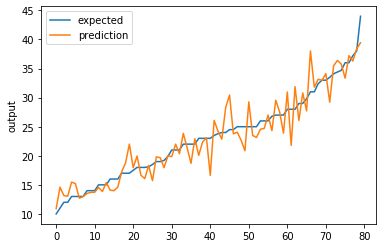

In [10]:
# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test)

### Try varying optimizer paramters and batch size after class. 

### References:

* [Google Colab](https://colab.research.google.com/) - Free web based platform that includes Python, Juypter Notebooks, and TensorFlow with free GPU support.  No setup needed.
* [IBM Cognitive Class Labs](https://www.datascientistworkbench.com) - Free web based platform that includes Python, Juypter Notebooks, and TensorFlow.  No setup needed.
* [Python Anaconda](https://www.continuum.io/downloads) - Python distribution that includes many data science packages, such as Numpy, Scipy, Scikit-Learn, Pandas, and much more.
* [TensorFlow](https://www.tensorflow.org/) - Google's mathematics package for deep learning.
* [Kaggle](https://www.kaggle.com/) - Competitive data science.  Good source of sample data.
* T81-558: Applications of Deep Neural Networks. Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/)